In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

df = pd.read_csv("diabetes.csv")

In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)       # Python random module
    np.random.seed(seed_value)    # NumPy
    torch.manual_seed(seed_value) # CPU seed for PyTorch

    # If you are using CUDA:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # for multi-GPU setups

    # Additionally, to ensure further reproducibility
    # you might need to set the following flags:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # You can specify your own seed here

In [3]:
X = df.drop('Outcome', axis = 1).values
y = df['Outcome'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_valid_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
#Define the Single Layer Perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(8, 1)  # 8 input features, 1 output (binary classification)

    def forward(self, x):
        x = self.fc(x)            # Linear combination
        x = torch.sigmoid(x)      # Sigmoid activation function for binary classification
        return x

In [6]:
def train(model, epochs, opt, learning_rate, weight_decay):
    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = opt(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(epochs):
        # Set the model to training mode
        model.train()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Calculate training accuracy
        predicted = (outputs >= 0.5).float()  # Apply threshold to get binary output
        correct = (predicted == y_train_tensor).float().sum()
        train_accuracy = correct / y_train_tensor.shape[0]

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation step
        if epoch + 1 == epochs:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                valid_outputs = model(X_valid_tensor)
                valid_loss = criterion(valid_outputs, y_valid_tensor)
                
                # Calculate validation accuracy
                predicted_valid = (valid_outputs >= 0.5).float()  # Apply threshold to get binary output
                correct_valid = (predicted_valid == y_valid_tensor).float().sum()
                validation_accuracy = correct_valid / y_valid_tensor.shape[0]
            
            print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}')


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def report(model):
    # Testing the model on validation set
    with torch.no_grad():
        # Get predictions, round them to 0 or 1
        y_pred_tensor = model(X_valid_tensor).round()

        # Convert PyTorch tensors to NumPy arrays for compatibility with sklearn
        y_pred = y_pred_tensor.cpu().numpy()  # Move to CPU if using CUDA
        y_true = y_valid_tensor.cpu().numpy()  # Move to CPU if using CUDA

        # Generate and print classification report
        report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
        print("Classification Report:\n", report)

        # Generate and print confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Visualize the confusion matrix as a heatmap
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()





Training model: epochs 10
Training Accuracy: 0.6826, Validation Accuracy: 0.7013
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.59      0.72       100
     Class 1       0.54      0.91      0.68        54

    accuracy                           0.70       154
   macro avg       0.73      0.75      0.70       154
weighted avg       0.79      0.70      0.71       154



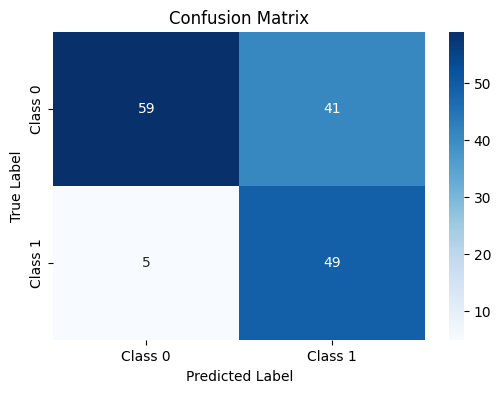



Training model: epochs 100
Training Accuracy: 0.7804, Validation Accuracy: 0.7662
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81       100
     Class 1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154



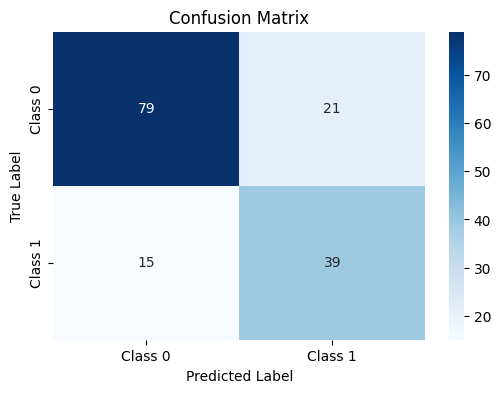



Training model: epochs 1000
Training Accuracy: 0.7935, Validation Accuracy: 0.7338
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80       100
     Class 1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



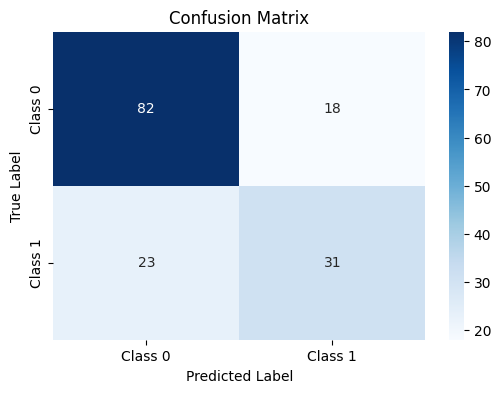

In [8]:
epochs = [10, 100, 1000]

for epoch in epochs:
    set_seed()
    model = SingleLayerPerceptron()

    print(f"\n\nTraining model: epochs {epoch}")

    train(model, epoch, optim.Adam, 0.01, 0)
    report(model)



Training model: learning rate 0.1, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.7804, Validation Accuracy: 0.7597
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.84      0.82       100
     Class 1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



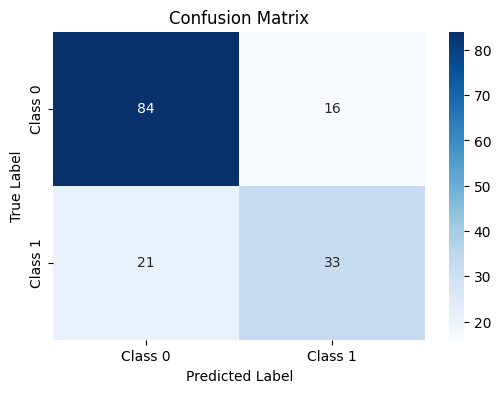



Training model: learning rate 0.1, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.7935, Validation Accuracy: 0.7338
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80       100
     Class 1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



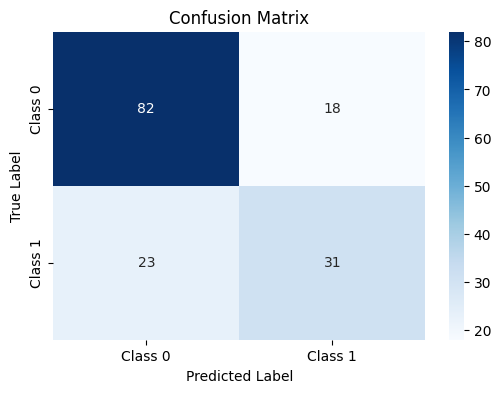



Training model: learning rate 0.01, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.6826, Validation Accuracy: 0.7273
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.64      0.75       100
     Class 1       0.57      0.89      0.70        54

    accuracy                           0.73       154
   macro avg       0.74      0.76      0.72       154
weighted avg       0.79      0.73      0.73       154



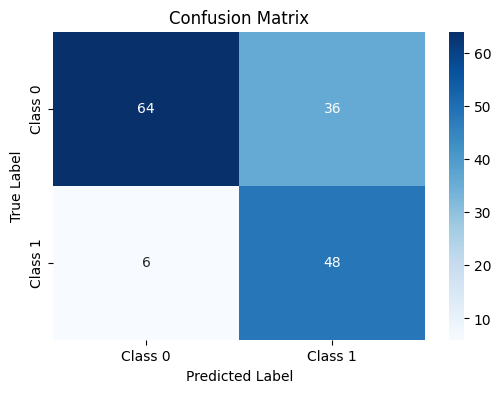



Training model: learning rate 0.01, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.7804, Validation Accuracy: 0.7662
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81       100
     Class 1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154



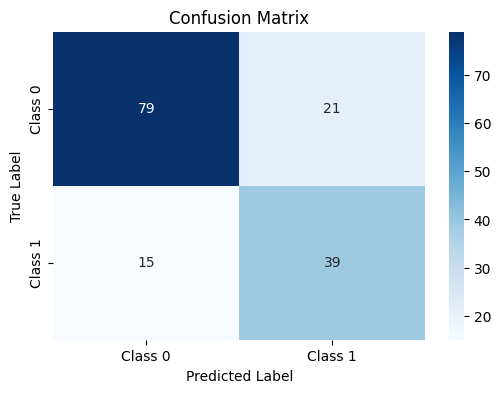



Training model: learning rate 0.001, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.6109, Validation Accuracy: 0.6623
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.51      0.66       100
     Class 1       0.51      0.94      0.66        54

    accuracy                           0.66       154
   macro avg       0.73      0.73      0.66       154
weighted avg       0.79      0.66      0.66       154



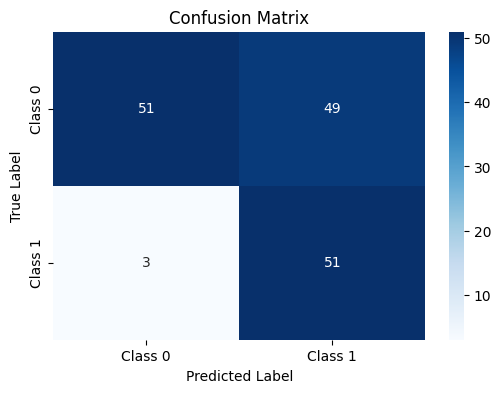



Training model: learning rate 0.001, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.6783, Validation Accuracy: 0.6883
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.57      0.70       100
     Class 1       0.53      0.91      0.67        54

    accuracy                           0.69       154
   macro avg       0.73      0.74      0.69       154
weighted avg       0.78      0.69      0.69       154



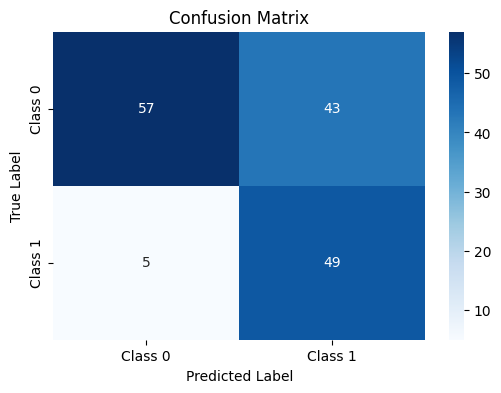

In [9]:
lr_rates = [0.1, 0.01, 0.001]
opts = [optim.SGD, optim.Adam]


for lr in lr_rates:
    for opt in opts:
        set_seed()
        model = SingleLayerPerceptron()

        print(f"\n\nTraining model: learning rate {lr}, optimizer {opt}")

        train(model, 100, opt, lr, 0)
        report(model)
    



Training model: weight_decay 0.01
Training Accuracy: 0.7804, Validation Accuracy: 0.7532
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.82      0.80      0.81       100
     Class 1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154



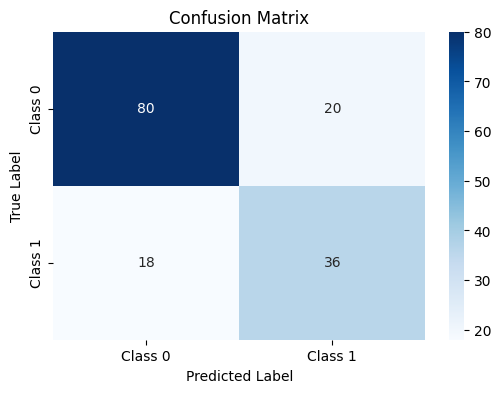



Training model: weight_decay 0.001
Training Accuracy: 0.7826, Validation Accuracy: 0.7662
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81       100
     Class 1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154



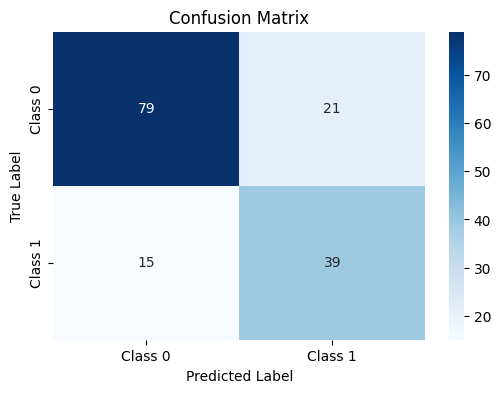



Training model: weight_decay 0
Training Accuracy: 0.7804, Validation Accuracy: 0.7662
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81       100
     Class 1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154



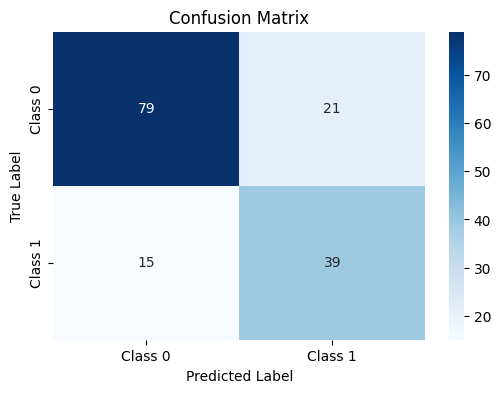

In [10]:
weight_decays = [0.01, 0.001, 0]


for weight_decay in weight_decays:
    set_seed()
    model = SingleLayerPerceptron()

    print(f"\n\nTraining model: weight_decay {weight_decay}")

    train(model, 100, optim.Adam, 0.01, weight_decay)
    report(model)

In [11]:

# Define the model with one hidden layer
class MLP(nn.Module):
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(8, hidden_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hidden_output = self.relu(self.hidden_layer(x))
        output = self.output_layer(hidden_output)
        return self.sigmoid(output)  




Training model: learning rate 0.1, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.7500, Validation Accuracy: 0.7403
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.77      0.85      0.81       100
     Class 1       0.66      0.54      0.59        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.73      0.74      0.73       154



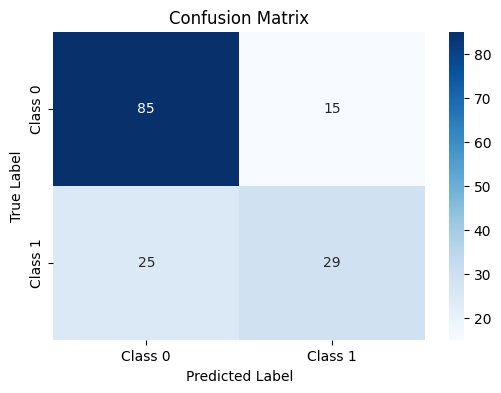



Training model: learning rate 0.1, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.8348, Validation Accuracy: 0.7922
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.86      0.84       100
     Class 1       0.72      0.67      0.69        54

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



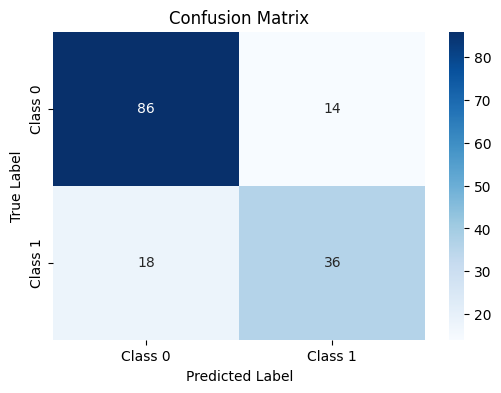



Training model: learning rate 0.01, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.6478, Validation Accuracy: 0.6753
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.66      0.73       100
     Class 1       0.53      0.70      0.60        54

    accuracy                           0.68       154
   macro avg       0.67      0.68      0.66       154
weighted avg       0.71      0.68      0.68       154



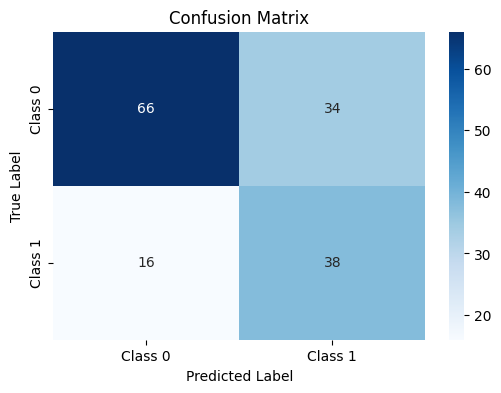



Training model: learning rate 0.01, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.7891, Validation Accuracy: 0.7273
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.78      0.81      0.79       100
     Class 1       0.62      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.70       154
weighted avg       0.72      0.73      0.72       154



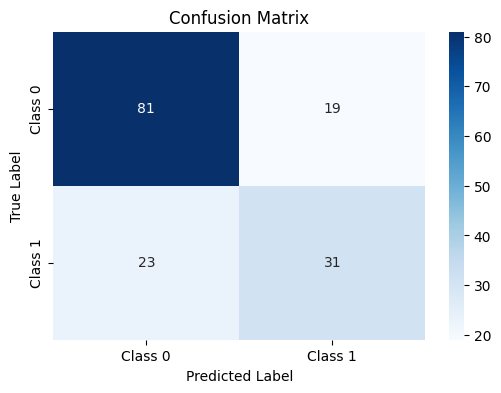



Training model: learning rate 0.001, optimizer <class 'torch.optim.sgd.SGD'>
Training Accuracy: 0.5087, Validation Accuracy: 0.5584
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.33      0.49       100
     Class 1       0.44      0.98      0.61        54

    accuracy                           0.56       154
   macro avg       0.71      0.66      0.55       154
weighted avg       0.79      0.56      0.53       154



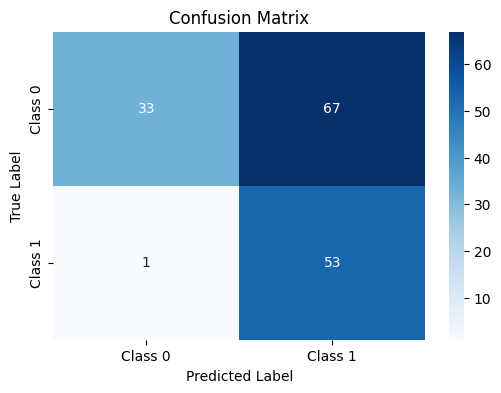



Training model: learning rate 0.001, optimizer <class 'torch.optim.adam.Adam'>
Training Accuracy: 0.6652, Validation Accuracy: 0.7208
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.66      0.75       100
     Class 1       0.57      0.83      0.68        54

    accuracy                           0.72       154
   macro avg       0.72      0.75      0.72       154
weighted avg       0.77      0.72      0.73       154



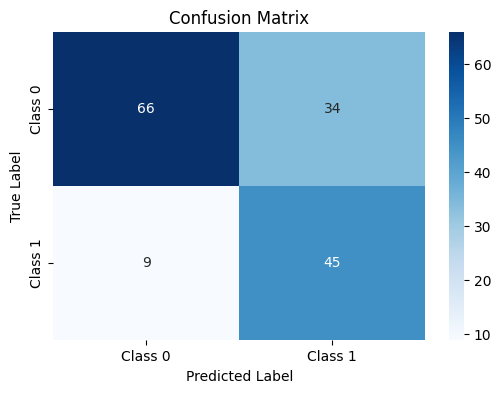

In [12]:
lr_rates = [0.1, 0.01, 0.001]
opts = [optim.SGD, optim.Adam]

for lr in lr_rates:
    for opt in opts:
        set_seed()
        model = MLP(4)

        print(f"\n\nTraining model: learning rate {lr}, optimizer {opt}")

        train(model, 100, opt, lr, 0)
        report(model)



Training model: weight_decay 0.01
Training Accuracy: 0.8065, Validation Accuracy: 0.7662
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.85      0.83       100
     Class 1       0.69      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



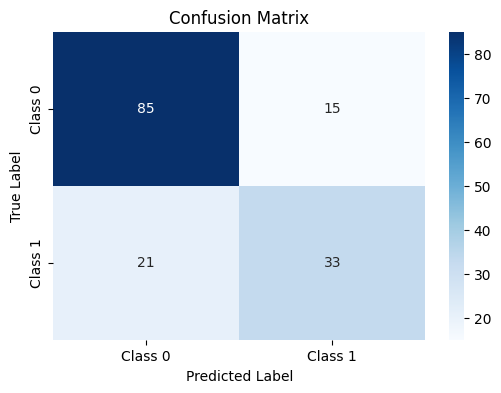



Training model: weight_decay 0.001
Training Accuracy: 0.8326, Validation Accuracy: 0.7922
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.86      0.84       100
     Class 1       0.72      0.67      0.69        54

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



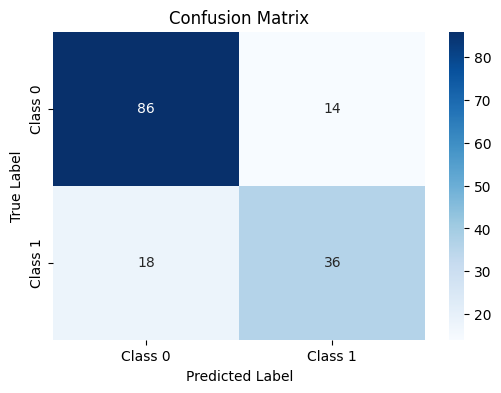



Training model: weight_decay 0
Training Accuracy: 0.8348, Validation Accuracy: 0.7922
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.86      0.84       100
     Class 1       0.72      0.67      0.69        54

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



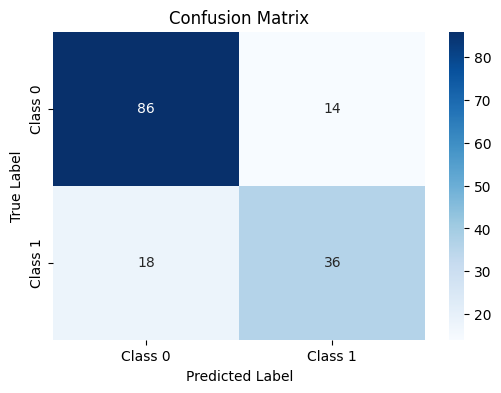

In [13]:
weight_decays = [0.01, 0.001, 0]


for weight_decay in weight_decays:
    set_seed()
    model = MLP(4)

    print(f"\n\nTraining model: weight_decay {weight_decay}")

    train(model, 100, optim.Adam, 0.1, weight_decay)
    report(model)

Training Accuracy: 0.8348, Validation Accuracy: 0.7922
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.65      0.67      0.66       101
     Class 1       0.34      0.32      0.33        53

    accuracy                           0.55       154
   macro avg       0.50      0.50      0.50       154
weighted avg       0.55      0.55      0.55       154

Confusion Matrix:
 [[68 33]
 [36 17]]


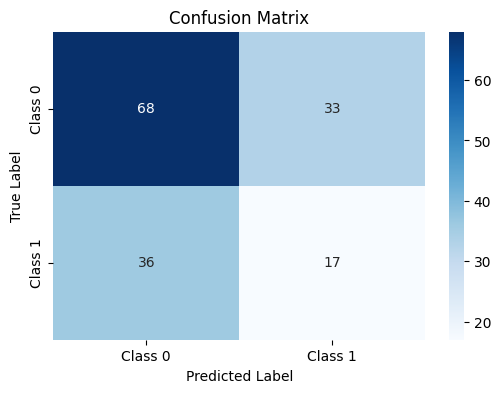

In [14]:
set_seed()
model = MLP(4)
train(model, 100, optim.Adam, 0.1, 0)

with torch.no_grad():
        # Get predictions, round them to 0 or 1
        y_pred_tensor = model(X_valid_tensor).round()

        # Convert PyTorch tensors to NumPy arrays for compatibility with sklearn
        y_pred = y_pred_tensor.cpu().numpy()  # Move to CPU if using CUDA
        y_true = y_test_tensor.cpu().numpy()  # Move to CPU if using CUDA

        # Generate and print classification report
        report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
        print("Classification Report:\n", report)

        # Generate and print confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Visualize the confusion matrix as a heatmap
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()